In [0]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import time
import random
from os import listdir
import functools
import pickle
import math
from IPython import display as ipythondisplay
from tqdm import tqdm

import subprocess
import regex as re

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay


from IPython.display import Audio
from string import Formatter

def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  return ipythondisplay.Image('tmp.png')


def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()



class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()
        
cwd = os.getcwd()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# for House music change 'balladArr.pkl' to 'houseArr.pkl' (and also change the path to where you put it in your google drive), for poprock it is poprockArr.pkl
infile = open('drive/Shared drives/Digital Musicology 2020/ModelDatasets/poprockArr.pkl','rb')
data = pickle.load(infile)
infile.close()

In [4]:
data = data.reindex(np.random.permutation(data.index))
data

,0,1,2,3
8748,0 1 2 3 0 0.050...,0 1 2 3 0 0.88849...,0 1 2 3 0 0.047...,0 1 2 3 0 0.05179...
191,0 1 2 3 0 0.037...,0 1 2 3 0 0.03715...,0 1 2 3 0 0.051...,0 1 2 3 0 0.046...
8888,0 1 2 3 0 0.037...,0 1 2 3 0 0.282...,0 1 2 3 0 0.0316...,0 1 2 3 0 0.78140...
2207,0 1 2 3 0 0.211...,0 1 2 3 0 0.436...,0 1 2 3 0 0.211301...,0 1 2 3 0 0.21130...
3955,0 1 2 3 0 0.1...,0 1 2 3 0 39.21260...,0 1 2 3 0 45.56905...,0 1 2 3 0 0.893...
...,...,...,...,...
2424,0 1 2 3 0 0.1467...,0 1 2 3 0 0.369...,0 1 2 3 0 0.146...,0 1 2 3 0 1.489792...
5809,0 1 2 3 0 0.1143...,0 1 2 3 0 0.1143...,0 1 2 3 0 0.1143...,0 1 2 3 0 0.2536...
7792,0 1 2 3 0 0.041...,0 1 2 3 0 1.46750...,0 1 2 3 0 0.386...,0 1 2 3 0 0.04128...
3343,0 1 2 3 0 0.008...,0 1 2 3 0 0.9702...,0 1 2 3 0 0.008...,0 1 2 3 0 0.0082...


In [5]:
testSize = int(len(data) * .15)
testSet = data[:testSize].reset_index(drop=True)
testSet

,0,1,2,3
0,0 1 2 3 0 0.050...,0 1 2 3 0 0.88849...,0 1 2 3 0 0.047...,0 1 2 3 0 0.05179...
1,0 1 2 3 0 0.037...,0 1 2 3 0 0.03715...,0 1 2 3 0 0.051...,0 1 2 3 0 0.046...
2,0 1 2 3 0 0.037...,0 1 2 3 0 0.282...,0 1 2 3 0 0.0316...,0 1 2 3 0 0.78140...
3,0 1 2 3 0 0.211...,0 1 2 3 0 0.436...,0 1 2 3 0 0.211301...,0 1 2 3 0 0.21130...
4,0 1 2 3 0 0.1...,0 1 2 3 0 39.21260...,0 1 2 3 0 45.56905...,0 1 2 3 0 0.893...
...,...,...,...,...
1482,0 1 2 3 0 1.99691...,0 1 2 3 0 0.112...,0 1 2 3 0 6.78684...,0 1 2 3 0 3.89431...
1483,0 1 2 3 0 0.144...,0 1 2 3 0 0.13416...,0 1 2 3 0 0.13416...,0 1 2 3 0 0.13416...
1484,0 1 2 3 0 0.015...,0 1 2 3 0 0.27863...,0 1 2 3 0 0.278...,0 1 2 3 0 0.01105...
1485,0 1 2 3 0 0.0145...,0 1 2 3 0 0.0145...,0 1 2 3 0 0.014...,0 1 2 3 0 10.29804...


In [6]:
genre = data[testSize:].reset_index(drop=True)
genre

,0,1,2,3
0,0 1 2 3 0 0.3820...,0 1 2 3 0 0.791689...,0 1 2 3 0 1.2032...,0 1 2 3 0 0.382073...
1,0 1 2 3 0 0.038...,0 1 2 3 0 0.309...,0 1 2 3 0 0.0464...,0 1 2 3 0 1.230655...
2,0 1 2 3 0 0.092...,0 1 2 3 0 0.341...,0 1 2 3 0 2.05883...,0 1 2 3 0 1.840708...
3,0 1 2 3 0 4.79190...,0 1 2 3 0 4.79190...,0 1 2 3 0 0.018...,0 1 2 3 0 4.79190...
4,0 1 2 3 0 0.078...,0 1 2 3 0 9.67378...,0 1 2 3 0 0.071...,0 1 2 3 0 0.07144...
...,...,...,...,...
8422,0 1 2 3 0 0.1467...,0 1 2 3 0 0.369...,0 1 2 3 0 0.146...,0 1 2 3 0 1.489792...
8423,0 1 2 3 0 0.1143...,0 1 2 3 0 0.1143...,0 1 2 3 0 0.1143...,0 1 2 3 0 0.2536...
8424,0 1 2 3 0 0.041...,0 1 2 3 0 1.46750...,0 1 2 3 0 0.386...,0 1 2 3 0 0.04128...
8425,0 1 2 3 0 0.008...,0 1 2 3 0 0.9702...,0 1 2 3 0 0.008...,0 1 2 3 0 0.0082...


In [0]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
   
  model = tf.keras.Sequential([
   
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    
   LSTM(rnn_units), 
    
    tf.keras.layers.Dense(vocab_size)
    
  ])

  return model

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss


In [0]:
def encode_notes_full(notesArr):
    size = math.ceil(notesArr[-1:][1])
    sizeF = size*4
    mod = sizeF%batchSize
    pad = 0
    if(mod != 0):
         pad = batchSize - mod
    encodeNotes =  pd.DataFrame([[0.0]*30]*(sizeF+pad))
    length = len(notesArr)
    count = 0
    partInt=0
    for i in range(length):
        start = notesArr[0][i]
        count = 0
        end = notesArr[1][i]
        dur = float(end) - float(start)
        startInt = int(float(start))
        part = float(start) - startInt
        index = (startInt)*4
        if(part<=0.25):
            partInt = 0
        elif(0.25<part<=0.5):
            partInt = 1
        elif(0.5<part<=0.75):
            partInt = 2
        elif(0.75<part<=1.0):
            partInt = 3
        
        for j in range(29):
            if(encodeNotes[j][index + partInt]==0.0 and encodeNotes[j+1][index + partInt]==0.0 and encodeNotes[j+2][index + partInt]==0.0):
                
                encodeNotes[j][index + partInt] = dur
                encodeNotes[j+1][index + partInt] = notesArr[2][i]
                encodeNotes[j+2][index + partInt] = notesArr[3][i]
                break
    return encodeNotes

def cut_output(y_hat, instrument ):
    if(instrument=='drums'):
      y_hat = y_hat[:,0:30]
    if(instrument=='piano'):
      y_hat = y_hat[:,30:60]
    if(instrument=='guitar'):
      y_hat = y_hat[:,60:90]
    if(instrument=='bass'):
      y_hat = y_hat[:,90:120]
    return y_hat

def get_encoded_song( songNum, instrument):
    drums = encode_notes_full(genre[0][songNum])
    piano = encode_notes_full(genre[1][songNum])
    guitar = encode_notes_full(genre[2][songNum])
    bass = encode_notes_full(genre[3][songNum])
    fullSong = pd.concat([drums, piano, guitar, bass], axis=1, sort=False)
    fullSong.fillna(0.0, inplace=True)
    if(instrument=='drums'):
        drums.fillna(0.0, inplace=True)
        return fullSong, drums
    if(instrument=='piano'):
        piano.fillna(0.0, inplace=True)
        return fullSong, piano
    if(instrument=='guitar'):
        guitar.fillna(0.0, inplace=True)
        return fullSong, guitar
    if(instrument=='bass'):
        bass.fillna(0.0, inplace=True)
        return fullSong, bass
    
def get_batchF(encodedNotes, encodedIns1, iteration, batchSize):

    idx = int(iteration * batchSize)
    input_batch = encodedNotes[idx:(idx+batchSize)].values
    output_batch = encodedIns1[(idx+batchSize):(idx+(batchSize*2))].values
    output_batch[output_batch > 200] = 200
    output_batch[output_batch < 0] = 0
    input_batch[input_batch > 200] = 200
    input_batch[input_batch < 0] = 0
    return input_batch, output_batch

In [0]:
modelF = build_model(200, embedding_dim=512, rnn_units=2048, batch_size=60)

In [0]:
# \/\/\/ Change this for each of the four models to the correct instrument you are training
instrument = 'piano'
genreName = 'poprock' #put either house or poprock, depending which one you chose

num_training_iterations = 4*len(genre)
learning_rate = 5e-3 
totalSongs = len(genre) - 1
batchSize = 60

#remember to instantiate this directory before hand (i.e. /housebass/) 
#Each model needs its own checkpoint directory
#Change upstream directory to match your google drive
checkpoint_dir = 'drive/Shared drives/Digital Musicology 2020/PoprockMusicData/' + genreName + instrument 
checkpoint_prefix = os.path.join(checkpoint_dir, genreName + instrument)

# This is for restarting training at a particular iteration
iteration_restart = 20604
if (iteration_restart>0):
    modelF.load_weights(checkpoint_prefix)


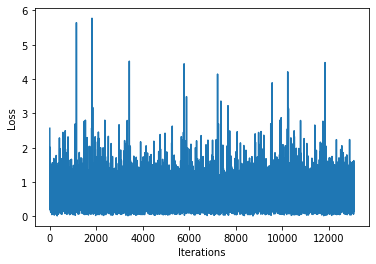

100%|██████████| 33708/33708 [2:04:47<00:00,  4.50it/s]

0


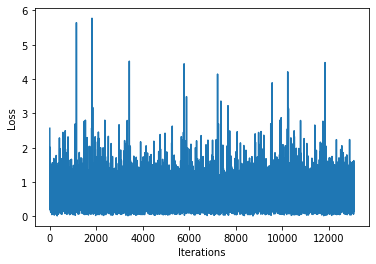

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 

  with tf.GradientTape() as tape:
  
    y_hat = modelF(x) 
    y_hat = cut_output(y_hat, instrument)
    loss = compute_loss(y, y_hat) 

 
  grads = tape.gradient(loss, modelF.trainable_variables) 
  
  optimizer.apply_gradients(zip(grads, modelF.trainable_variables))
  return loss

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() 
for iter in tqdm(range(num_training_iterations)):
  if (iteration_restart<=iter):
      if (iter>totalSongs):
          songNum = iter%totalSongs
      else: 
          songNum = iter
      
      song, ins = get_encoded_song(songNum, instrument)
      
      for j in range(int(min((len(song)/batchSize)-1,int((len(ins)/batchSize)-1)))):
          print(j)
          x_batch, y_batch = get_batchF(song, ins, j, batchSize)
          loss = train_step(x_batch, y_batch)
          
      history.append(loss.numpy().mean())
      plotter.plot(history)

      if(iter % 100 == 0):     
              print('Saved')
              modelF.save_weights(checkpoint_prefix)
      

modelF.save_weights(checkpoint_prefix)